# First MindSpore Neural Network - MNIST Classifier

Make Your First GAN With MindSpore, 2022

In [1]:
# import libraries

import mindspore
import mindspore.nn as nn
import mindspore.dataset as ds

import pandas
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(mindspore.__version__, mindspore.context.get_context('device_target'))

1.6.1 Ascend


## DataSet Class

In [3]:
# dataset class

class MnistDataset:
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = np.zeros((10), dtype=np.float32)
        target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = np.array(self.data_df.iloc[index,1:].values, dtype=np.float32) / 255.0
        
        # return image data tensor and target tensor
        return image_values, target
    
    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
    


## Load Data

In [4]:
mnist_train_dataset = MnistDataset( './dataset/mnist/mnist_train.csv')

batch_size = 16
train_dataset = ds.GeneratorDataset(mnist_train_dataset, ['image', 'target']).batch(batch_size)

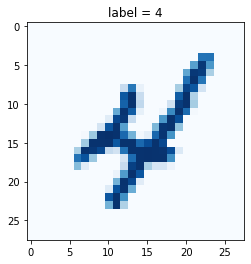

In [5]:
# check data contains images

mnist_train_dataset.plot_image(9)

In [6]:
# check Dataset class can be accessed by index, returns image values and target tensor

mnist_train_dataset[100]

(array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  

## Neural Network Class

In [7]:
from datetime import datetime
from mindspore.train.callback import Callback

# classifier class
class Classifier(nn.Cell):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.SequentialCell(
            nn.Dense(784, 200),
            nn.Sigmoid(),
            nn.Dense(200, 10),
            nn.Sigmoid()
        )
        
        # create loss function
        loss_fn = nn.MSELoss()
        # create optimizer, using simple stochastic gradient descent
        optimizer = nn.SGD(self.model.trainable_params(), learning_rate=0.1)

        self.model_train = mindspore.Model(self.model, loss_fn=loss_fn, optimizer=optimizer)

        # accumulator for progress
        self.progress = []
    
    def construct(self, inputs):
        # simply run model
        return self.model(inputs)

    def train(self, epochs, dataset):
        class LossCallback(Callback):
            def __init__(self, progress):
                super().__init__()
                self.progress = progress

            def epoch_begin(self, run_context):
                cb_params = run_context.original_args()
                print(f'{datetime.now()}： start epoch {cb_params.cur_epoch_num} of {epochs}:')
            
            def step_end(self, run_context):
                cb_params = run_context.original_args()
                step_num = cb_params.cur_step_num
                if step_num % 10 == 0:
                    loss = cb_params.net_outputs
                    self.progress.append(loss.asnumpy())
                if step_num % 1000 == 0:
                    print(f'{datetime.now()}: counter = {step_num}')

        self.model_train.train(epochs, dataset, callbacks=[LossCallback(self.progress)], dataset_sink_mode=False)

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


## Train Neural Network

In [8]:
%%time

from datetime import datetime

# create neural network

C = Classifier()

# train network on MNIST data set

epochs = 8
C.train(epochs, train_dataset)

2022-05-21 16:11:49.080888： start epoch 1 of 8:
2022-05-21 16:12:23.994045: counter = 1000
2022-05-21 16:12:33.799769: counter = 2000
2022-05-21 16:12:43.566110: counter = 3000
2022-05-21 16:12:51.001757： start epoch 2 of 8:
2022-05-21 16:12:53.489642: counter = 4000
2022-05-21 16:13:03.440270: counter = 5000
2022-05-21 16:13:13.324890: counter = 6000
2022-05-21 16:13:23.245056: counter = 7000
2022-05-21 16:13:28.218773： start epoch 3 of 8:
2022-05-21 16:13:33.175945: counter = 8000
2022-05-21 16:13:43.108555: counter = 9000
2022-05-21 16:13:53.040750: counter = 10000
2022-05-21 16:14:02.959323: counter = 11000
2022-05-21 16:14:05.457163： start epoch 4 of 8:
2022-05-21 16:14:12.920380: counter = 12000
2022-05-21 16:14:22.816719: counter = 13000
2022-05-21 16:14:32.739297: counter = 14000
2022-05-21 16:14:42.701727: counter = 15000
2022-05-21 16:14:42.703441： start epoch 5 of 8:
2022-05-21 16:14:52.640150: counter = 16000
2022-05-21 16:15:02.572089: counter = 17000
2022-05-21 16:15:12.4

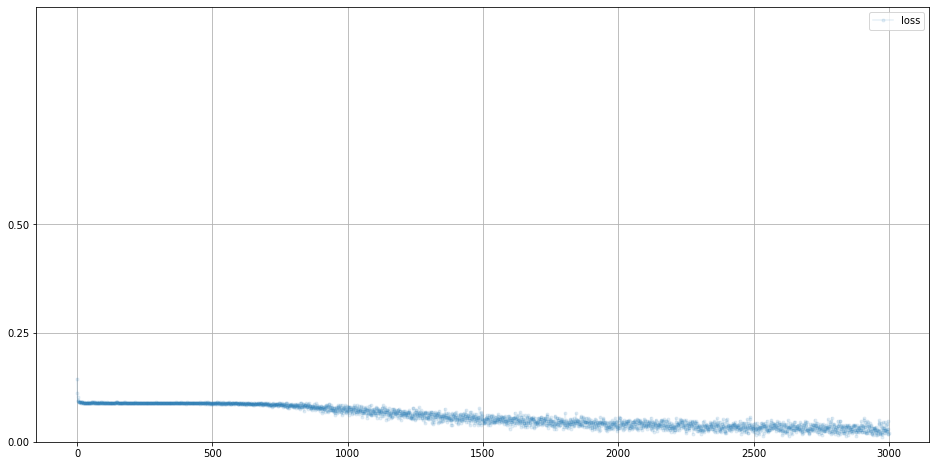

In [9]:
# plot classifier error

C.plot_progress()

## Classification Example

In [10]:
# load MNIST test data

mnist_test_dataset = MnistDataset( './dataset/mnist/mnist_test.csv')

test_dataset = ds.GeneratorDataset(mnist_test_dataset, ['image', 'target'], shuffle=False).batch(1)

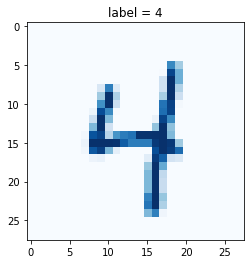

In [11]:
# pick a record
record = 19

# plot image and correct label
mnist_test_dataset.plot_image(record)

<AxesSubplot:>

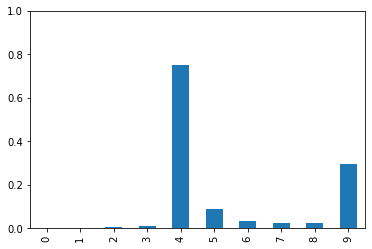

In [12]:
# visualise the answer given by the neural network

image_data = mindspore.ops.ExpandDims()(mindspore.Tensor(mnist_test_dataset[record][0]), 0)

# query from trained network
output = C.construct(image_data)[0]

# plot output tensor
pandas.DataFrame(output.asnumpy()).plot(kind='bar', legend=False, ylim=(0,1))

## Classifier Performance

In [13]:
# test trained neural network on training data

score = 0
items = 0

for image_data_tensor, target_tensor in test_dataset:
    target = target_tensor[0].asnumpy()
    answer = C.construct(image_data_tensor)[0].asnumpy()
    if (answer.argmax() == target.argmax()):
        score += 1
    items += 1

print(score, items, score/items)

8754 10000 0.8754
